Approach to split text into chunks without losing semantic meaning.
Based and inspired by [Link](https://medium.com/@npolovinkin/how-to-chunk-text-into-paragraphs-using-python-8ae66be38ea6#d8e5)

# Imports

In [1]:
import logging as logger
import math
import os

import fitz
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import warnings

In [2]:
logger.basicConfig(level=logger.INFO)
warnings.simplefilter("ignore")

In [3]:
DOC_PATH = os.path.join("data", "test.pdf")

# Functions

## Visualization

In [4]:
def plot_chunk_points(activated_similarities: np.array, split_points: list) -> None:
    """Plot chunk points in document using activted similarities

    Args:
        activated_similarities (np.array): activated similarities
        split_points (list): split points in document to create chunks
    """
    fig, axes = plt.subplots(figsize=(12, 6))
    axes.plot(activated_similarities, label="Activated Similarities")
    axes.scatter(
        split_points,
        [activated_similarities[i] for i in split_points],
        color="red",
        label="Split points",
    )
    axes.set_xlabel("Sentence Index")
    axes.set_ylabel("Activated Similarity Value")
    axes.set_title("Change Points in Document based on activated similarities")
    axes.legend()
    fig.tight_layout()

## Helper Functions

In [5]:
def calc_rev_sigmoid(x: float) -> float:
    """calculate reverse sigmoid function

    Args:
        x (float): input value

    Returns:
        float: output value
    """
    return 1 / (1 + math.exp(0.5 * x))

In [6]:
def activate_similarities(similarities: np.array, p_size=10) -> np.array:
    """calculate activated similarities using reverse sigmoid function

    Args:
        similarities (np.array): similarities between sentences
        p_size (int, optional): size of sigmoid function. Defaults to 10.

    Returns:
        np.array: activated similarities
    """
    x = np.linspace(-10, 10, p_size)
    y = np.vectorize(calc_rev_sigmoid)
    activation_weights = np.pad(y(x), (0, similarities.shape[0] - p_size))
    diagonals = [
        similarities.diagonal(each) for each in range(0, similarities.shape[0])
    ]
    diagonals = [
        np.pad(each, (0, similarities.shape[0] - len(each))) for each in diagonals
    ]
    diagonals = np.stack(diagonals)
    diagonals = diagonals * activation_weights.reshape(-1, 1)
    activated_similarities = np.sum(diagonals, axis=0)
    return activated_similarities

# Chunk text

In [7]:
doc = fitz.open(DOC_PATH)
text = str()
for page in doc:
    text += page.get_text()

print(text)

Getty Images
Why you should care about data
privacy even if you have “nothing to
hide”
Yes, your data is used to sell you shoes. But it also may be used to sell you an
ideology.
By Sara Morrison 
 Jan 28, 2021, 1:10pm EST
When I tell people I write about data privacy, I usually get something along the lines of
these two responses:
“Is Facebook listening to me? I got an ad for parrot food, and the only possible explanation
is that Facebook heard my friend tell me about his new pet parrot, because he mentioned
that exact brand, which I never even heard of before.”
(No, Facebook isn’t.)
Here’s the other:
“I’m sure that’s important to someone, but I don’t have anything to hide. Why should I care
about data privacy?”
A ton of personal and granular data is collected about us every day through our phones,
computers, cars, homes, televisions, smart speakers — anything that’s connected to the
internet, basically, as well as things that aren’t, like credit card purchases and even the
information

In [8]:
# load sentence transformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
sentences = text.split(".")

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


In [9]:
# create embeddings for sentences and calculate similarities
embeddings = model.encode(sentences)
similarities = cosine_similarity(embeddings)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

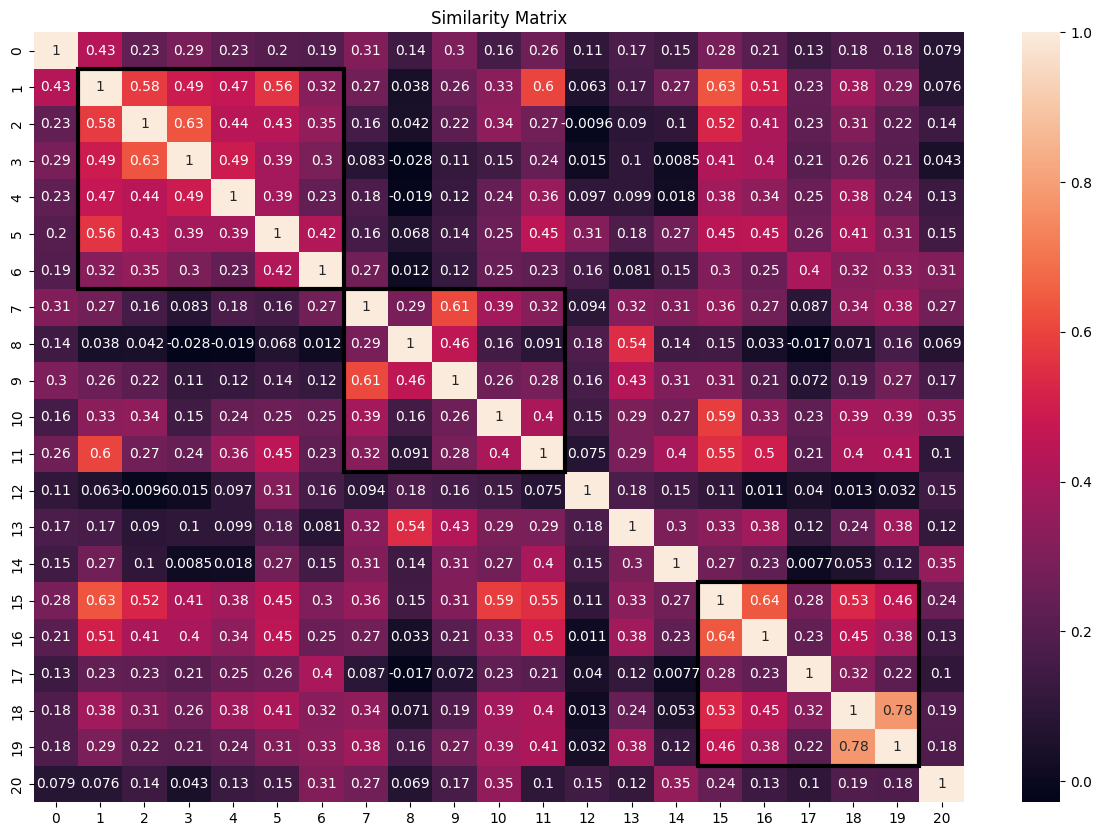

In [48]:
import seaborn as sns

fig, axes = plt.subplots(figsize=(15, 10))
sns.heatmap(similarities[9:30, 9:30], annot=True).set_title("Similarity Matrix")
# draw rectangle around similar sentences
axes.add_patch(
    plt.Rectangle((1, 1), 6, 6, fill=False, edgecolor="black", lw=3, clip_on=False)
)
axes.add_patch(
    plt.Rectangle((7, 7), 5, 5, fill=False, edgecolor="black", lw=3, clip_on=False)
)
axes.add_patch(
    plt.Rectangle((15, 15), 5, 5, fill=False, edgecolor="black", lw=3, clip_on=False)
)

In [18]:
# calculate activated similarities
activated_similarities = activate_similarities(similarities, p_size=5)
minima = argrelextrema(activated_similarities, np.less, order=2)
split_points = [each for each in minima[0]]

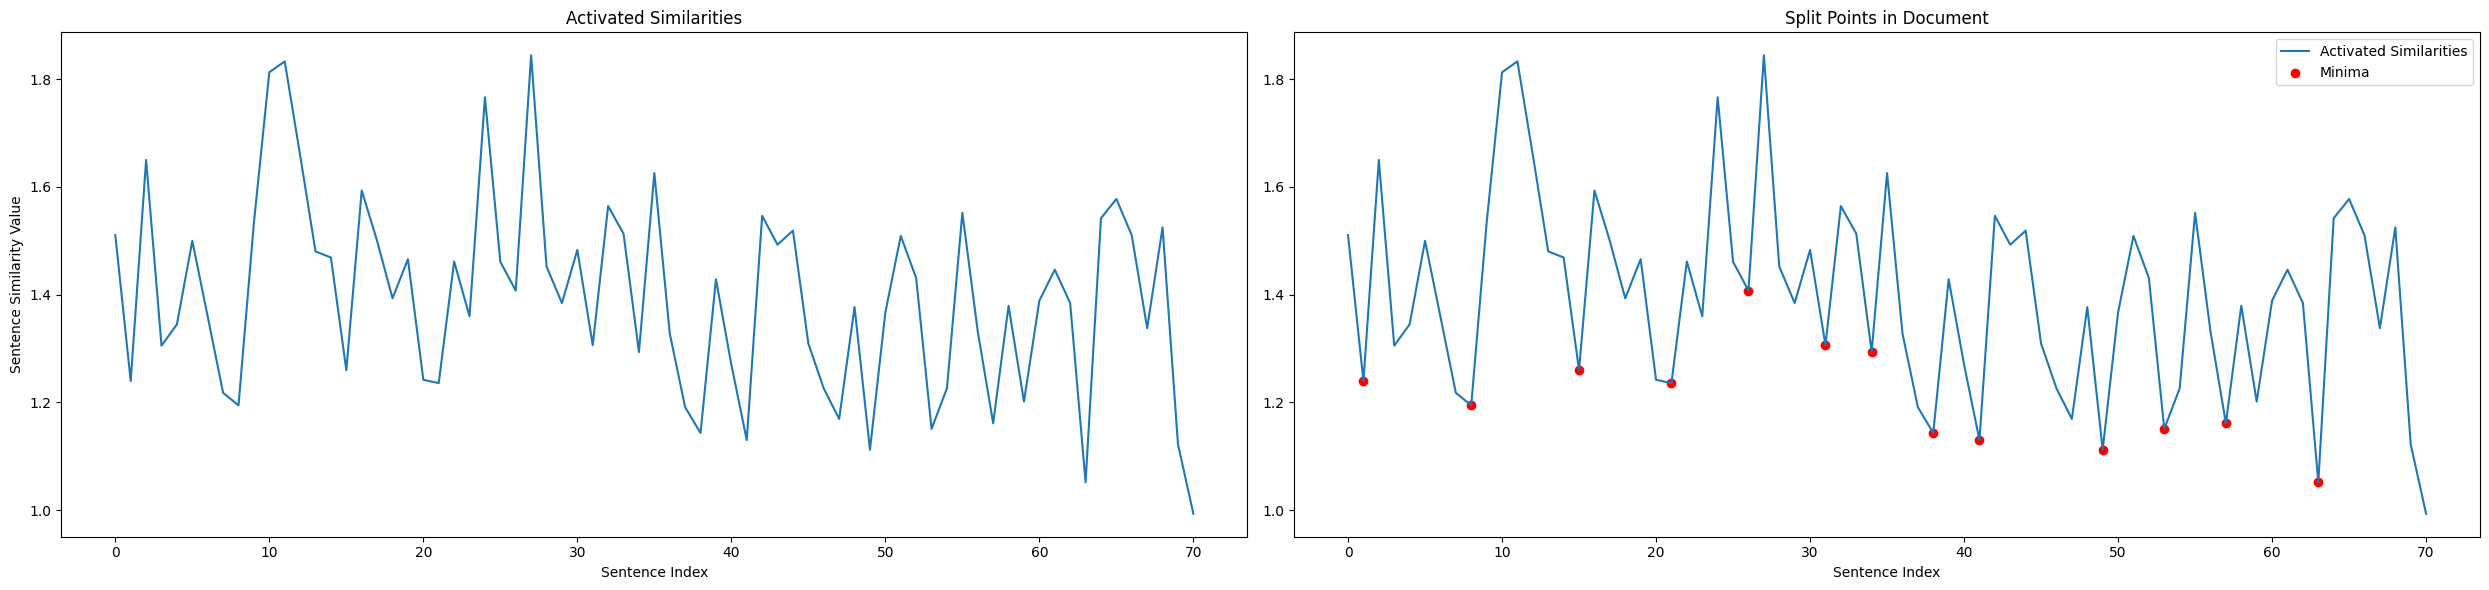

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(25, 6))
axes.flatten()
axes[0].plot(activated_similarities, label="Activated Similarities")
axes[0].set_xlabel("Sentence Index")
axes[0].set_ylabel("Sentence Similarity Value")
axes[0].set_title("Activated Similarities")

axes[1].plot(activated_similarities, label="Activated Similarities")
axes[1].scatter(
    minima[0],
    [activated_similarities[i] for i in minima[0]],
    color="red",
    label="Minima",
)
axes[1].set_xlabel("Sentence Index")
axes[1].set_title("Split Points in Document")
axes[1].legend()

fig.tight_layout()